In [2]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [4]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
val_cnt = data_list.encoding.value_counts()
# data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 5 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [5]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
tags.remove('O')
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('Gender', 'O', 'NN'), ('does', 'O', 'VBZ'), ('not', 'O', 'RB'), ('typically', 'O', 'RB'), ('affect', 'O', 'JJ'), ('IOP', 'O', 'NNP'), ('and', 'O', 'CC'), ('aging', 'GO:0007568', 'VBG'), ('results', 'O', 'NNS'), ('in', 'O', 'IN'), ('an', 'O', 'DT'), ('IOP', 'O', 'NNP'), ('decrease', 'O', 'NN'), ('in', 'O', 'IN'), ('some', 'O', 'DT'), ('strains', 'O', 'NNS'), ('.', 'O', '.')]
7893
16445
1806
44


In [6]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [7]:
print(tag2idx)

{'1_GO:0044301': 913, '2_GO:0071736': 1, 'GO:0051259': 1631, 'GO:0002027': 1148, '1_GO:0008217': 915, '2_GO:0097152': 606, '1_GO:0017001': 1633, '2_GO:0045095': 2, '3_GO:0006094': 914, '2_GO:0005912': 3, '2_GO:0001714': 404, '1_GO:0007608': 916, '2_GO:0007492': 917, '2_GO:0014019': 918, '2_GO:0006749': 920, '2_GO:0035262': 5, '2_GO:0030216': 921, '2_GO:0005576': 1557, '4_GO:0043277': 922, '2_GO:0048286': 6, '2_GO:0007598': 7, 'GO:0030056': 8, '1_GO:0060041': 925, '3_GO:0042461': 926, 'GO:0007126': 927, '3_GO:0007598': 9, '3_GO:0021982': 928, '1_GO:0008595': 1265, '1_GO:0038179': 929, '3_GO:0033186': 930, '3_GO:0016605': 931, 'GO:0005764': 10, '3_GO:0006805': 302, '3_GO:0046907': 932, 'GO:0050917': 933, '1_GO:0009653': 11, '2_GO:0070997': 934, '1_GO:1903522': 935, '5_GO:0060428': 12, '3_GO:0031507': 13, '2_GO:0014010': 14, '1_GO:0032984': 15, 'GO:0030016': 938, '3_GO:0044853': 769, '3_GO:0015031': 939, 'GO:0007608': 16, 'GO:0005929': 17, '2_GO:0008021': 940, 'GO:0006887': 941, '3_GO:005

In [8]:
print(pos2idx)

{'RP': 2, 'VBZ': 3, 'NNS': 4, 'VBD': 5, 'WDT': 6, '$': 8, 'FW': 9, ',': 10, 'PRP': 11, 'RBR': 12, ':': 13, 'NNPS': 14, 'JJS': 15, 'WRB': 38, 'DT': 16, 'VBN': 1, 'VBG': 17, 'WP$': 35, 'JJ': 18, '``': 21, 'VB': 22, 'NN': 23, 'PDT': 24, 'MD': 25, 'NNP': 26, "''": 27, 'CD': 28, 'IN': 7, '#': 19, '.': 29, '(': 30, 'X': 0, 'SYM': 20, 'RB': 31, 'UH': 32, 'JJR': 33, 'WP': 34, 'PRP$': 36, 'EX': 40, 'CC': 37, 'RBS': 39, 'POS': 42, 'VBP': 41, 'TO': 43, ')': 44}


In [9]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [10]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [11]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

128


In [12]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [13]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [14]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [15]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [16]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags + 1) for i in y]

In [17]:
from keras.preprocessing.text import Tokenizer
from numpy import asarray, zeros
docs =  [[w[0] for w in s] for s in data_list]
# define class labels
labels = y[:]
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = n_words + 2
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of 4 words
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
# load the whole embedding into memory
embeddings_index = dict()
f = open('../data/bionlp/PubMed-and-PMC-w2v.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 4087447 word vectors.


In [18]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [51]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# input and embedding for words
word_in = Input(shape=(max_len,))

emb_word = Embedding(input_dim=n_words + 2, output_dim=200,
                     input_length=max_len,
                     weights=[embedding_matrix], trainable=False)(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_in, pos_in, char_in], out)

In [52]:
from keras.optimizers import RMSprop
import keras.backend as K

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

w_array = np.ones((10,10))
w_array[1, 7] = 1.2
w_array[7, 1] = 1.2

ncce = partial(customLoss, weights=np.ones((10,10)))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=["acc"])
# model.compile(optimizer=rmsopt, loss='categorical_crossentropy', metrics=["acc"])

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 75, 15, 100)  13000       input_9[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 75, 15, 100)  0           time_distributed_7[0][0]         
__________________________________________________________________________________________________
input_8 (I

In [54]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-BioNLP.png')

In [55]:
from keras.callbacks import EarlyStopping
history = model.fit([X_word_tr, X_pos_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=20, validation_data=([X_word_te, X_pos_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te)),
                    verbose=1)

Train on 5525 samples, validate on 2368 samples
Epoch 1/20
5525/5525 [==============================] - 48s 9ms/step - loss: 1011.2507 - acc: 0.9253 - val_loss: 548.1763 - val_acc: 0.9369
Epoch 2/20
5525/5525 [==============================] - 50s 9ms/step - loss: 521.8666 - acc: 0.9372 - val_loss: 504.6223 - val_acc: 0.9390
Epoch 3/20
5525/5525 [==============================] - 51s 9ms/step - loss: 464.9306 - acc: 0.9392 - val_loss: 454.0024 - val_acc: 0.9415
Epoch 4/20
5525/5525 [==============================] - 51s 9ms/step - loss: 415.7306 - acc: 0.9425 - val_loss: 422.1197 - val_acc: 0.9471
Epoch 5/20
5525/5525 [==============================] - 51s 9ms/step - loss: 372.6291 - acc: 0.9469 - val_loss: 386.4734 - val_acc: 0.9520
Epoch 6/20
5525/5525 [==============================] - 51s 9ms/step - loss: 339.3641 - acc: 0.9501 - val_loss: 369.7372 - val_acc: 0.9553
Epoch 7/20
5525/5525 [==============================] - 51s 9ms/step - loss: 312.6610 - acc: 0.9537 - val_loss: 340.6

In [56]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-BioNLP.tsv', sep='\t')

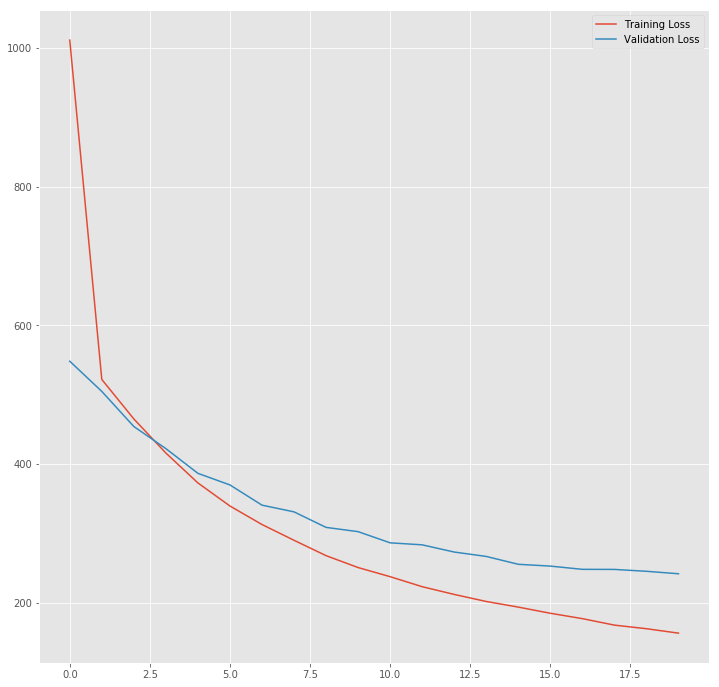

In [57]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

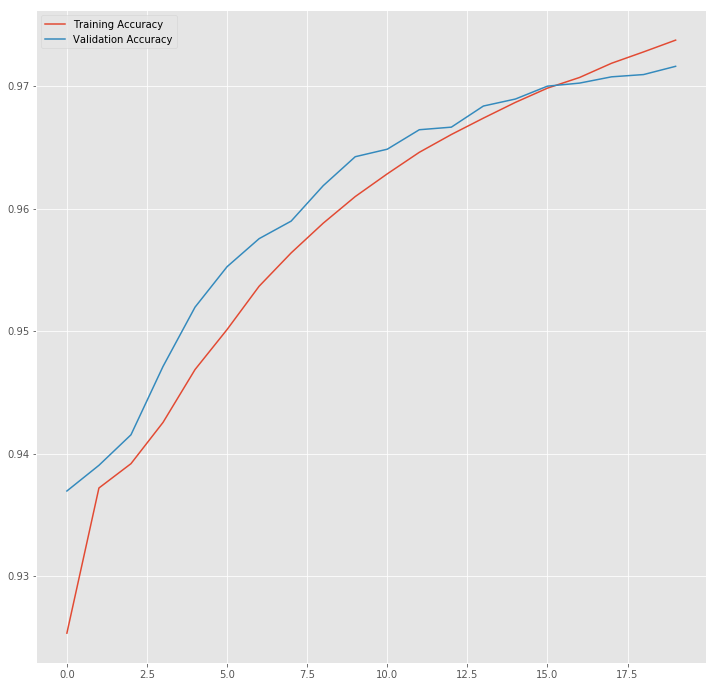

In [58]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te, X_pos_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000077       0.00      0.00      0.00         1
1_GO:0000086       0.00      0.00      0.00         1
1_GO:0000187       0.00      0.00      0.00         1
1_GO:0000322       0.00      0.00      0.00         2
1_GO:0000380       1.00      1.00      1.00        10
1_GO:0000725       0.80      1.00      0.89         4
1_GO:0000795       1.00      1.00      1.00         1
1_GO:0000803       1.00      1.00      1.00         4
1_GO:0000805       0.29      1.00      0.44         2
1_GO:0000806       1.00      0.89      0.94         9
1_GO:0001171       1.00      0.40      0.57         5
1_GO:0001501       0.00      0.00      0.00         2
1_GO:0001502       0.00      0.00      0.00         3
1_GO:0001568       0.00      0.00      0.00         1
1_GO:0001654       0.50      0.33      0.40         3
1_GO:0001658       0.00      0.00      0.00         6
1_GO:0001676       0.00      0.00      0.00         1
1_GO:0001709       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [60]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[tr], idx2tag[pred]))

[  0   0   0 737   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
Chimeric       : O     O
males          : O     O
were           : O     O
mated          : GO:0007618 GO:0007618
with           : O     O
129P2/OlaHsd   : O     O
females        : O     O
.              : O     O


In [61]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [62]:
df = df[df['Word'] != 'O']

In [63]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000077       0.00      0.00      0.00         1
1_GO:0000086       0.00      0.00      0.00         1
1_GO:0000187       0.00      0.00      0.00         1
1_GO:0000322       0.00      0.00      0.00         2
1_GO:0000380       1.00      1.00      1.00        10
1_GO:0000725       0.80      1.00      0.89         4
1_GO:0000795       1.00      1.00      1.00         1
1_GO:0000803       1.00      1.00      1.00         4
1_GO:0000805       0.29      1.00      0.44         2
1_GO:0000806       1.00      0.89      0.94         9
1_GO:0001171       1.00      0.40      0.57         5
1_GO:0001501       0.00      0.00      0.00         2
1_GO:0001502       0.00      0.00      0.00         3
1_GO:0001568       0.00      0.00      0.00         1
1_GO:0001654       0.50      0.33      0.40         3
1_GO:0001658       0.00      0.00      0.00         6
1_GO:0001676       0.00      0.00      0.00         1
1_GO:0001709       0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
